## Following parameters are set in the simulations
- P = number of people
- V = number of vehicles
- W, L = width and length of the (rectangular) region where individuals move (in meters)
- Np = level of noise (dB) produced by each person
- Nv = level of noise (dB) produced by each vehicle
- Dp = distance (side of the square area, in meters) affected by the presence of a person
- Dv = distance (side of the square area, in meters) affected by the presence of a vehicle
- Vp = moving speed for an individual
- Vv = moving speed for a vehicle
- t = time step (in seconds): the simulation recomputes the position of people and vehicle, and the level of noise of each square meter in the region with a temporal granularity of t (simulated) seconds

In [31]:
## Parameters all in meter
number_of_people = 1000
number_of_vehicles = 1000
area_of_movemenet = 1000
noise_level_people = 50
noise_level_vehicles = 70
affected_area_by_people = 10
affected_area_by_vehicles = 20
moving_speed_people = 8 # km/h
moving_speed_vehicles = 50 #km/h

In [128]:
import numpy as np
import random
import pandas as pd
import geopandas as geopd
#import movingpandas as mpd
from shapely.geometry import Point, LineString, Polygon, box, mapping
from datetime import datetime
from pyproj import CRS
from datetime import datetime
import math
from functools import reduce, partial
#import h3pandas as h3
import h3

ModuleNotFoundError: No module named 'h3'

In [163]:
%%time
## loading geojson of the german map and its regions
import os
fname = "resources/2_hoch.geojson.json"
file = open(fname)
df = geopd.read_file(file)
gdf = geopd.GeoDataFrame(df)
gdf = gdf.to_crs(epsg=3763)


CPU times: user 527 ms, sys: 51.4 ms, total: 579 ms
Wall time: 697 ms


In [164]:
gdf['area_size'] = gdf['geometry'].area
gdf.sort_values(by=['area_size'])
#gdf.plot(figsize=(10, 10))

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry,area_size
153,86,DEU,Germany,2,Bayern,11,Unterfranken,137,Schweinfurt Städte,None,None,Kreisfreie Städte,Urban district,"POLYGON ((1310704.438 1321023.112, 1310923.412...",3.807898e+07
103,86,DEU,Germany,2,Bayern,7,Oberbayern,87,Rosenheim Städte,None,None,Kreisfreie Städte,Urban district,"POLYGON ((1512728.210 1114790.395, 1513376.355...",3.962358e+07
71,86,DEU,Germany,2,Bayern,5,Mittelfranken,55,Schwabach Städte,None,None,Kreisfreie Städte,Urban district,"POLYGON ((1392408.589 1254075.975, 1392926.587...",4.218242e+07
219,86,DEU,Germany,8,Mecklenburg-Vorpommern,19,Mecklenburg-Vorpommern,203,Stralsund Städte,None,None,Kreisfreie Städte,Urban district,"POLYGON ((1368585.450 1841422.546, 1368890.083...",4.276265e+07
137,86,DEU,Germany,2,Bayern,10,Schwaben,121,Kaufbeuren Städte,None,None,Kreisfreie Städte,Urban district,"POLYGON ((1400985.334 1090149.755, 1401193.429...",4.304720e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,86,DEU,Germany,8,Mecklenburg-Vorpommern,19,Mecklenburg-Vorpommern,192,Ludwigslust,None,None,Landkreise,Rural district,"POLYGON ((1254742.289 1725448.049, 1256102.669...",2.632941e+09
169,86,DEU,Germany,4,Brandenburg,13,Brandenburg,153,Ostprignitz-Ruppin,None,None,Landkreise,Rural district,"POLYGON ((1355546.100 1714772.389, 1356067.799...",2.646973e+09
170,86,DEU,Germany,4,Brandenburg,13,Brandenburg,154,Potsdam-Mittelmark,None,None,Landkreise,Rural district,"POLYGON ((1435789.028 1635776.088, 1434858.027...",2.841665e+09
255,86,DEU,Germany,9,Niedersachsen,23,Weser-Ems,239,Emsland,None,None,Landkreise,Rural district,"POLYGON ((1027834.633 1599510.076, 1027586.139...",2.910653e+09


In [161]:
%%time
## preparing the base map of the region that is currently utilized

#interate_map = gdf['NAME_3']
brandenburgdf = gdf[gdf['NAME_3'] == 'Potsdam Städte']
brandenburgbase = brandenburgdf.plot(color='white', edgecolor='black', cmap='Reds', figsize=(10, 10))
#polygon_bounding_box = Polygon([(polygon.bounds.minx.values[0], polygon.bounds.miny.values[0]), (polygon.bounds.maxx.values[0], polygon.bounds.miny.values[0]), (polygon.bounds.maxx.values[0], polygon.bounds.maxy.values[0]), (polygon.bounds.minx.values[0], polygon.bounds.maxy.values[0])])

#tet = interate_map.apply(lambda x: print(x))


KeyError: 'NAME_3'

In [159]:
## span entities within the polygon of the region
#spawned_point = Point(random.uniform(polygon.bounds.minx.values[0], polygon.bounds.maxx.values[0]), random.uniform(polygon.bounds.miny.values[0], polygon.bounds.maxy.values[0]))

x_coord_adding = random.randrange(-100, 100)
y_coord_adding = random.randrange(-100, 100)
def add_needed_col_to_vehicle(df):
    df['type']='vehicle'
    df['history']=[]
    df['movement_direction']={'add_to_x':random.randrange(-moving_speed_vehicles, moving_speed_vehicles),'add_to_y': random.randrange(-moving_speed_vehicles,moving_speed_vehicles)}
    df['movement_area']=df['geometry'].buffer(area_of_movemenet, cap_style=3)
    df['movement_speed']= moving_speed_vehicles    
    df['noise_volume']= noise_level_vehicles
    df['noise_pollution_area']= affected_area_by_vehicles
    return df

def add_needed_col_to_people(df):
    df['type']='person'
    df['history']=[]
    df['movement_direction']={'add_to_x':random.randrange(-moving_speed_people, moving_speed_people),'add_to_y': random.randrange(-moving_speed_people,moving_speed_people)}
    df['movement_area']=df['geometry'].buffer(area_of_movemenet, cap_style=3)
    df['movement_speed']= moving_speed_people    
    df['noise_volume']= noise_level_people
    df['noise_pollution_area']= affected_area_by_people
    return df

def spawnpeople(region_object_row):
    counter_people = 0
    counter_vehicle = 0

    spawned_people = []
    spawned_vehicles = []
    #print(region_object_row['NAME_3'])
    #print(type(region_object_row))
    polygon = region_object_row['geometry']

    while len(spawned_people) < number_of_people: 
        spawned_point = Point(random.uniform(polygon.bounds.minx.values[0], polygon.bounds.maxx.values[0]), random.uniform(polygon.bounds.miny.values[0], polygon.bounds.maxy.values[0]))
        if(region_object_row['geometry'].contains(spawned_point).values[0]):
            spawned_people.append(spawned_point)
        counter_people += 1  

    while len(spawned_vehicles) < number_of_vehicles: 
        spawned_point = Point(random.uniform(polygon.bounds.minx.values[0], polygon.bounds.maxx.values[0]), random.uniform(polygon.bounds.miny.values[0], polygon.bounds.maxy.values[0]))
        if(region_object_row['geometry'].contains(spawned_point).values[0]):
            spawned_vehicles.append(spawned_point)
        counter_vehicle += 1
        
    #transforming data to Dataframe and adding columns for PEOPLE
    spawned_people_df = pd.DataFrame(spawned_people, columns = ['geometry'])
    spawned_people_geodf = geopd.GeoDataFrame(spawned_people_df, crs=3763)
    spawned_people_geodf = spawned_people_geodf.apply(add_needed_col_to_people, axis=1)

    #transforming data to Dataframe and adding columns for VEHICLES
    spawned_vehicles_df = pd.DataFrame(spawned_vehicles, columns = ['geometry'])
    spawned_vehicles_geodf = geopd.GeoDataFrame(spawned_vehicles_df, crs=3763)
    spawned_vehicles_geodf = spawned_vehicles_geodf.apply(add_needed_col_to_vehicle, axis=1)

    frames = [spawned_vehicles_geodf, spawned_people_geodf]
    result = pd.concat(frames, ignore_index=True)
    print(region_object_row['NAME_3'].values[0])
    result['region_affiliation'] =region_object_row['NAME_3'].values[0]
    #result['movement_area'] = region_object_row.iloc[0]['geometry']

    return result


In [148]:
### Spawning moving entities into regions that are defined in geojson -->for now just into the city Oldenburg

## preparing th    test2 = pd.DataFrame([i*2, i*3, i*4])
#test = pd.concat([test, test2], ignore_index=True)e base map of the spawned_vehicles, columns = ['geometry'])region that is currently utilized

gdf = gdf.to_crs(epsg=3763)
#brandenburgbase = brandenburgdf.plot(color='white', edgecolor='black', cmap='Reds', figsize=(10, 10))
polygon_bounding_box = Polygon([(1290773.81,1421304.01), (1292065.26,1421613.65), (1292294.97,1420691.03), (1290811.45,1420198.23)])
newDF = pd.DataFrame([], columns = ['geometry', 'type', 'region_affiliation','history','movement_direction','movement_speed','noise_volume','noise_pollution_area'])
#for index, row in gdf.iterrows():
gdf_oldenburg = gdf[gdf['NAME_3'] == 'Oldenburg']
#new_geodf = geopd.GeoDataFrame(data=[gdf_oldenburg], columns= ['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'ID_3', 'NAME_3', 'NL_NAME_3', 'VARNAME_3', 'TYPE_3', 'ENGTYPE_3', 'geometry'], crs=3763)
#newgeo = geopd.GeoSeries(data=row,crs=3763)
gdf_oldenburg['geometry'] = polygon_bounding_box
test2 = spawnpeople(gdf_oldenburg)
#test = pd.Series(test2, index = ['geometry', 'type', 'region_affiliation','history','movement_direction','movement_area','movement_speed','noise_volume','noise_pollution_area'])
newDF = newDF.append(test2, ignore_index=True)
gdf_oldenburg
    
    

/Users/aminhofmann/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/aminhofmann/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/aminhofmann/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values

Oldenburg


/var/folders/z5/3hh6k5k53jlgjlzdygqlzdg80000gn/T/ipykernel_18270/834513975.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newDF = newDF.append(test2, ignore_index=True)


,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry,area_size
0,86,DEU,Germany,9,Niedersachsen,23,Weser-Ems,244,Oldenburg,None,None,Landkreise,Rural district,"POLYGON ((1290773.810 1421304.010, 1292065.260...",1.142377e+09


In [165]:
### Spawning moving entities into regions that are defined in geojson -->for now just into the city Oldenburg

## preparing th    test2 = pd.DataFrame([i*2, i*3, i*4])
#test = pd.concat([test, test2], ignore_index=True)e base map of the spawned_vehicles, columns = ['geometry'])region that is currently utilized

gdf = gdf.to_crs(epsg=3763)
#brandenburgbase = brandenburgdf.plot(color='white', edgecolor='black', cmap='Reds', figsize=(10, 10))
#polygon_bounding_box = Polygon([(polygon.bounds.minx.values[0], polygon.bounds.miny.values[0]), (polygon.bounds.maxx.values[0], polygon.bounds.miny.values[0]), (polygon.bounds.maxx.values[0], polygon.bounds.maxy.values[0]), (polygon.bounds.minx.values[0], polygon.bounds.maxy.values[0])])

newDF = pd.DataFrame([], columns = ['geometry', 'type', 'region_affiliation','history','movement_direction','movement_speed','noise_volume','noise_pollution_area'])
#for index, row in gdf.iterrows():
gdf_oldenburg = gdf[gdf['NAME_3'] == 'Schweinfurt Städte']
#new_geodf = geopd.GeoDataFrame(data=[gdf_oldenburg], columns= ['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'ID_3', 'NAME_3', 'NL_NAME_3', 'VARNAME_3', 'TYPE_3', 'ENGTYPE_3', 'geometry'], crs=3763)
#newgeo = geopd.GeoSeries(data=row,crs=3763)
test2 = spawnpeople(gdf_oldenburg)
#test = pd.Series(test2, index = ['geometry', 'type', 'region_affiliation','history','movement_direction','movement_area','movement_speed','noise_volume','noise_pollution_area'])
newDF = newDF.append(test2, ignore_index=True)

    
    

/Users/aminhofmann/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/aminhofmann/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Schweinfurt Städte


/var/folders/z5/3hh6k5k53jlgjlzdygqlzdg80000gn/T/ipykernel_18270/28218199.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newDF = newDF.append(test2, ignore_index=True)


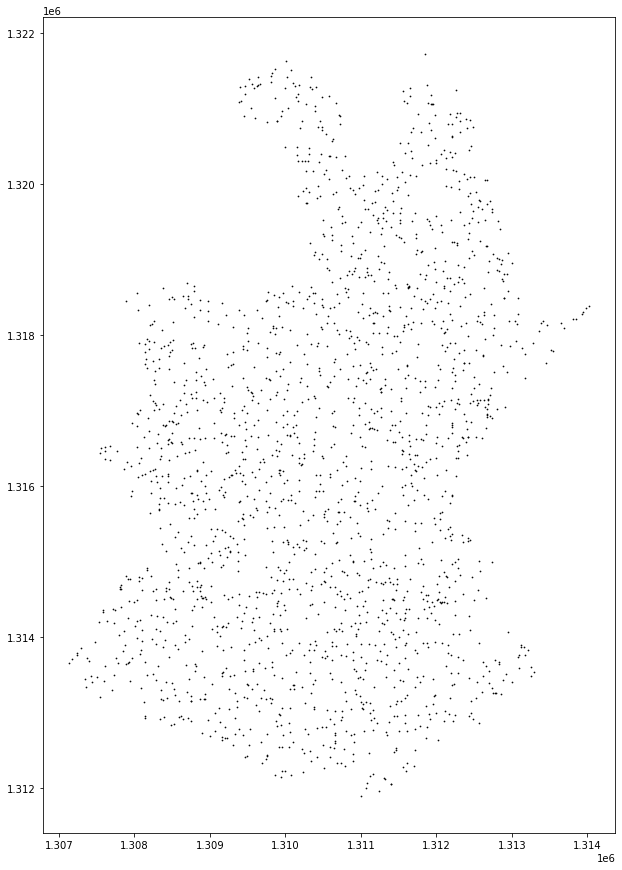

In [175]:
geonewdf= geopd.GeoDataFrame(newDF, crs=3763)
geonewdf = geonewdf.set_geometry('geometry')
fix = geonewdf.plot(color='white', edgecolor='black', markersize=0.5, figsize=(15, 15))

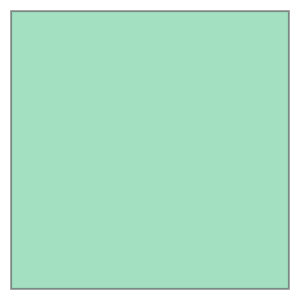

In [105]:
newDF.iloc[0]['movement_area']

In [382]:
## this can be ignored
#spawned_people_geodf = spawned_people_geodf.set_geometry('geometry')
#spawned_people_geodf.plot(ax=brandenburgbase, marker='o', color='white',edgecolor='red',markersize=3)
#spawned_people_geodf.plot(color='white', edgecolor='black', markersize=1)

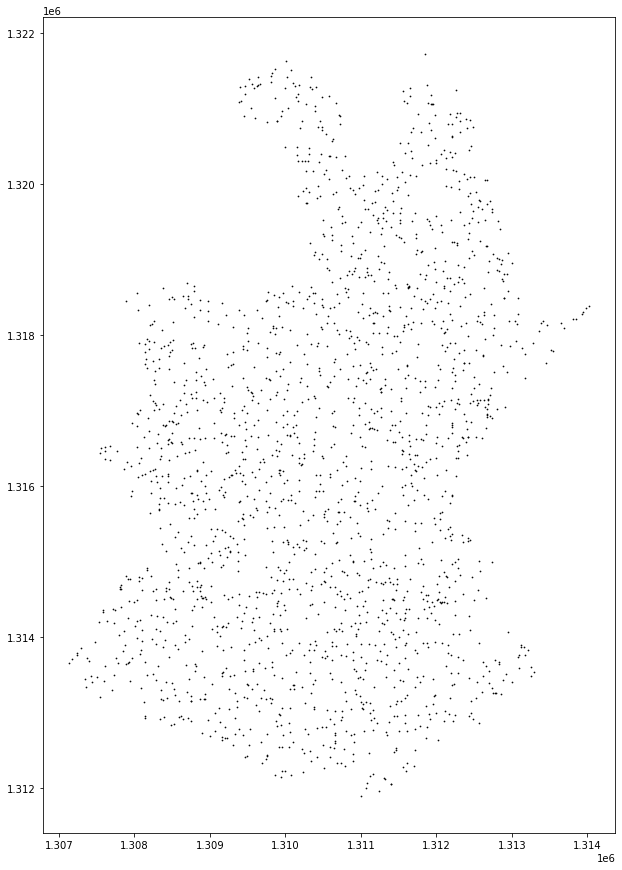

In [171]:
## here you can see the potitions of entities at moment x spawned in oldenburg
geonewdf= geopd.GeoDataFrame(newDF, crs=3763)
geonewdf = geonewdf.set_geometry('geometry')
fix = geonewdf.plot(color='white', edgecolor='black', markersize=0.5, figsize=(15, 15))
#geonewdf.hvplot(line_width=0.1, frame_width=800, frame_height=800)


### Run simulation of people movement

In [144]:
#test.apply(lambda x: x['history'].append({'geometry': x['geometry'], 't':datetime.now()}), axis=1)
def simulateMovement(array):
    test = array['history'].copy()
    test.append({'geometry': array['geometry'], 't':datetime.now()})
    array['history'] = test
    new_point =Point(array['geometry'].x + array['movement_direction']['add_to_x'], array['geometry'].y + array['movement_direction']['add_to_y'])
    while array['movement_area'].contains(new_point) != True:
        new_x_coord_adding = random.randrange(-100, 100)
        new_y_coord_adding = random.randrange(-100, 100)
        new_point =Point(array['geometry'].x + new_x_coord_adding, array['geometry'].y + new_y_coord_adding)
        array['movement_direction'] = {'add_to_x':new_x_coord_adding,'add_to_y': new_y_coord_adding}
    
    array['geometry'] = new_point
    return array
#test = spawned_people_geodf.apply(simulateMovement, axis=1)
#spawned_people_geodf

## simulation of people moving in a ploygon -->currently not using
brandenburgbase1 = brandenburgdf.plot(color='white', edgecolor='black', cmap='Reds', figsize=(10, 10))
while len(spawned_people_geodf['history'][0]) < 1000:    
    spawned_people_geodf= spawned_people_geodf.apply(simulateMovement, axis=1)
    #df = pd.DataFrame(spawned_people_geodf['history'][0]).set_index('t')
    gdf = geopd.GeoDataFrame(spawned_people_geodf, crs=CRS(3763))
    gdfbase = gdf.set_geometry("movement_area")
    #gdfbase = gdf.plot(edgecolor='black', cmap='Reds', figsize=(10, 10))
    gdfbase_with_movement = gdfbase.plot(ax=brandenburgbase1, marker='o', color='white',edgecolor='red',markersize=3)
    gdf.plot(ax=gdfbase_with_movement, marker='o', color='black',markersize=5)
    #agentsdf = gdf.to_crs(epsg=4326)
    #traj = mpd.Trajectory(agentsdf, 1)
    #test = traj.hvplot(geo=True, tiles='OSM', line_width=1, frame_width=500, frame_height=500)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.005)
    print(len(spawned_people_geodf['history'][0]))

In [152]:
spawned_people_geodf = newDF.copy()

In [153]:
## simulation of people moving in a ploygon
while len(spawned_people_geodf['history'][0]) < 5:    
    spawned_people_geodf= spawned_people_geodf.apply(simulateMovement, axis=1)
    #df = pd.DataFrame(spawned_people_geodf['history'][0]).set_index('t')
    gdf = geopd.GeoDataFrame(spawned_people_geodf, crs=CRS(3763))
    
    #frame = spawned_people_geodf.plot(color='green',markersize=3, figsize=(10, 10))
    #agentsdf = gdf.to_crs(epsg=4326)
    #traj = mpd.Trajectory(agentsdf, 1)
    #test = traj.hvplot(geo=True, tiles='OSM', line_width=1, frame_width=500, frame_height=500)
    #display.clear_output(wait=True)
    #display.display(pl.gcf())
    #time.sleep(1)
    print(len(spawned_people_geodf['history'][0]))

1
2
3
4
5


In [154]:
spawned_people_geodf

,geometry,type,region_affiliation,history,movement_direction,movement_speed,noise_volume,noise_pollution_area,movement_area
0,POINT (1291464.514 1420826.310),vehicle,Oldenburg,[{'geometry': POINT (1291349.5135490126 142099...,"{'add_to_x': 23, 'add_to_y': -34}",50,70,20,POLYGON ((1292349.5135490126 1421996.310158378...
1,POINT (1291444.368 1420924.098),vehicle,Oldenburg,[{'geometry': POINT (1291574.3681390798 142098...,"{'add_to_x': -26, 'add_to_y': -12}",50,70,20,POLYGON ((1292574.3681390798 1421984.097867306...
2,POINT (1290823.121 1420574.774),vehicle,Oldenburg,[{'geometry': POINT (1290833.1207636686 142072...,"{'add_to_x': -2, 'add_to_y': -30}",50,70,20,POLYGON ((1291833.1207636686 1421724.773718410...
3,POINT (1291931.896 1420530.684),vehicle,Oldenburg,[{'geometry': POINT (1291851.8956668116 142078...,"{'add_to_x': 16, 'add_to_y': -50}",50,70,20,"POLYGON ((1292851.8956668116 1421780.6843613, ..."
4,POINT (1291288.966 1420468.611),vehicle,Oldenburg,[{'geometry': POINT (1291143.965502367 1420313...,"{'add_to_x': 29, 'add_to_y': 31}",50,70,20,POLYGON ((1292143.965502367 1421313.6113409856...
...,...,...,...,...,...,...,...,...,...
1995,POINT (1290829.031 1421325.746),person,Oldenburg,[{'geometry': POINT (1290834.0314568302 142129...,"{'add_to_x': -1, 'add_to_y': 7}",8,50,10,POLYGON ((1291834.0314568302 1422290.746203417...
1996,POINT (1291262.945 1421170.283),person,Oldenburg,[{'geometry': POINT (1291242.9449691023 142113...,"{'add_to_x': 4, 'add_to_y': 7}",8,50,10,POLYGON ((1292242.9449691023 1422135.282645005...
1997,POINT (1290908.797 1421039.859),person,Oldenburg,[{'geometry': POINT (1290903.7970818155 142101...,"{'add_to_x': 1, 'add_to_y': 4}",8,50,10,POLYGON ((1291903.7970818155 1422019.858815825...
1998,POINT (1291887.800 1420755.465),person,Oldenburg,[{'geometry': POINT (1291907.8004874887 142076...,"{'add_to_x': -4, 'add_to_y': -1}",8,50,10,POLYGON ((1292907.8004874887 1421760.465277654...


In [157]:
#oldenburdf = spawned_people_geodf[spawned_people_geodf['region_affiliation'] == 'Oldenburg']
geo_oldenburg = geopd.GeoDataFrame(spawned_people_geodf, crs=3763)
geo_oldenburg['noise_pollution_area']= oldenburdf['geometry'].apply(lambda x: x.buffer(10, cap_style=1))
#geo_oldenburg = geo_oldenburg.set_geometry('noise_pollution_area')
#geo_oldenburg['geometry'] = geo_oldenburg['noise_pollution_area']
geo_oldenburg = geo_oldenburg.to_crs(4326)
#df = geo_oldenburg.h3.geo_to_h3(15)
geo_oldenburg


,geometry,type,region_affiliation,history,movement_direction,movement_speed,noise_volume,noise_pollution_area,movement_area
0,POINT (10.32585 50.97542),vehicle,Oldenburg,[{'geometry': POINT (1291349.5135490126 142099...,"{'add_to_x': 23, 'add_to_y': -34}",50,70,None,POLYGON ((1292349.5135490126 1421996.310158378...
1,POINT (10.32592 50.97630),vehicle,Oldenburg,[{'geometry': POINT (1291574.3681390798 142098...,"{'add_to_x': -26, 'add_to_y': -12}",50,70,None,POLYGON ((1292574.3681390798 1421984.097867306...
2,POINT (10.31631 50.97469),vehicle,Oldenburg,[{'geometry': POINT (1290833.1207636686 142072...,"{'add_to_x': -2, 'add_to_y': -30}",50,70,None,POLYGON ((1291833.1207636686 1421724.773718410...
3,POINT (10.33112 50.97187),vehicle,Oldenburg,[{'geometry': POINT (1291851.8956668116 142078...,"{'add_to_x': 16, 'add_to_y': -50}",50,70,None,"POLYGON ((1292851.8956668116 1421780.6843613, ..."
4,POINT (10.32223 50.97276),vehicle,Oldenburg,[{'geometry': POINT (1291143.965502367 1420313...,"{'add_to_x': 29, 'add_to_y': 31}",50,70,None,POLYGON ((1292143.965502367 1421313.6113409856...
...,...,...,...,...,...,...,...,...,...
1995,POINT (10.31902 50.98108),person,Oldenburg,[{'geometry': POINT (1290834.0314568302 142129...,"{'add_to_x': -1, 'add_to_y': 7}",8,50,None,POLYGON ((1291834.0314568302 1422290.746203417...
1996,POINT (10.32433 50.97880),person,Oldenburg,[{'geometry': POINT (1291242.9449691023 142113...,"{'add_to_x': 4, 'add_to_y': 7}",8,50,None,POLYGON ((1292242.9449691023 1422135.282645005...
1997,POINT (10.31909 50.97847),person,Oldenburg,[{'geometry': POINT (1290903.7970818155 142101...,"{'add_to_x': 1, 'add_to_y': 4}",8,50,None,POLYGON ((1291903.7970818155 1422019.858815825...
1998,POINT (10.33132 50.97388),person,Oldenburg,[{'geometry': POINT (1291907.8004874887 142076...,"{'add_to_x': -4, 'add_to_y': -1}",8,50,None,POLYGON ((1292907.8004874887 1421760.465277654...


In [111]:
geo_oldenburg_H3 = geo_oldenburg.h3.polyfill(15, explode=True)


AttributeError: 'GeoDataFrame' object has no attribute 'h3'

In [492]:
geo_oldenburg_H3.head(1)

,geometry,type,region_affiliation,history,movement_direction,movement_speed,noise_volume,noise_pollution_area,movement_area,h3_polyfill
0,"POLYGON ((10.32268 50.98041, 10.32268 50.98041...",vehicle,Oldenburg,[{'geometry': POINT (1291086.615565773 1421220...,"{'add_to_x': 3, 'add_to_y': 49}",50,70,"POLYGON ((1291102.615565773 1421318.18690883, ...","POLYGON ((1292086.615565773 1422220.18690883, ...",8f1fad1b16a4520


In [ ]:
geo_oldenburg_H3.hvplot(line_width=0.1, frame_width=800, frame_height=800)

In [496]:
count_series = geo_oldenburg_H3.groupby('h3_polyfill').size()
new_df = count_series.to_frame(name = 'amount').reset_index()
new_df.sort_values(by=['amount'])

,h3_polyfill,amount
0,8f1fad186112800,1
387414,8f1fad1b16cb665,1
387413,8f1fad1b16cb664,1
387412,8f1fad1b16cb663,1
387411,8f1fad1b16cb662,1
...,...,...
361861,8f1fad1b169dc13,7
361862,8f1fad1b169dc14,7
361889,8f1fad1b169dc33,7
361982,8f1fad1b169dcad,7


In [500]:
df_aggreg = counts_by_hexagon(df = geo_oldenburg_H3)


#df_aggreg.sort_values(by = "value", ascending = False, inplace = True)
# Creates a map using Folium
#hexmap = choropleth_map(df_aggreg = df_aggreg, with_legend = True)

TypeError: h3_to_geo_boundary() got an unexpected keyword argument 'h3_address'

In [117]:
import h3pandas as h3

resolution = 5
geo_oldenburg = geopd.GeoDataFrame(oldenburdf, crs=3763)
geo_oldenburg['noise_pollution_area']= oldenburdf['geometry'].apply(lambda x: x.buffer(10, cap_style=1))
geo_oldenburg = geo_oldenburg.set_geometry('noise_pollution_area')
geo_oldenburg = geo_oldenburg.to_crs(4326)
geo_oldenburg['count']=1
#geo_oldenburg = geo_oldenburg.drop(columns=['movement_speed', 'noise_volume','geometry'])
df = geo_oldenburg.h3.geo_to_h3(8)

#.groupby('h3_08').sum()
#df = df.h3.h3_to_geo_boundary()
#df.plot(column='count', figsize=(10, 10))

#df = geo_oldenburg.h3.geo_to_h3(6)

#polyfill_resample(4)

#box2 = geopd.GeoDataFrame(geometry=[box(adsa.bounds[0], adsa.bounds[1], adsa.bounds[2], adsa.bounds[3])])
#box2.h3.polyfill_resample(4)
#gdf = gpd.GeoDataFrame(geometry=[box(0, 0, 1, 1)])
#adsa.h3.polyfill(4, explode=True)


ValueError: x attribute access only provided for Point geometries

In [107]:
#geo_oldenburg = geo_oldenburg.set_geometry('noise_pollution_area')
#geo_oldenburg = geo_oldenburg.to_crs(3763)
#area = geo_oldenburg['noise_pollution_area'][0]
#geopd.GeoDataFrame(geometry=[area], crs=3763)

In [14]:
#poly1 = {'type': 'Polygon',
# 'coordinates': [[[37.813318999983238, -122.4089866999972145],
# [ 37.7866302000007224, -122.3805436999997056 ],
# [37.7198061999978478, -122.3544736999993603],
# [ 37.7076131999975672, -122.5123436999983966 ],
# [37.7835871999971715, -122.5247187000021967],
# [37.8151571999998453, -122.4798767000009008]]] }
#hexagons = h3.polyfill(poly1, 10)


In [15]:
#oldenburggg = gdf[gdf['NAME_3'] == 'Oldenburg']
#oldenburggg = oldenburggg.to_crs(4326)
#oldenburgbase = oldenburggg.plot(color='white', edgecolor='black', cmap='Reds')


In [16]:
#qeqweq = geopd.GeoDataFrame(geometry=[gdf['geometry'].iloc[0]], crs=3763)
#qqqq = qeqweq.to_crs(4326)
#qqqq.h3.polyfill(9)

In [17]:
#point = Point(1113609.354852433,1610841.474073912)
#circle_by_poitn_df = geopd.GeoDataFrame(geometry=[point], crs=3763)

#circle_by_poitn_df['geometry'] = circle_by_poitn_df['geometry'][0].buffer(10,0)
#circle_by_poitn_df = circle_by_poitn_df.to_crs(4326)
#circle_by_poitn_df['geometry'] = circle_by_poitn_df['geometry'][0].buffer(10,0)
#circle_by_poitn_df = circle_by_poitn_df.set_geometry('buffer')
#circle_by_poitn_df.h3.polyfill_resample(5).plot()


In [260]:
point = Point(1113609.354852433,1610841.474073912)
circle_by_poitn_df = geopd.GeoDataFrame(geometry=[point], crs=3763)

In [261]:
circle_by_poitn_df['geometry'] = circle_by_poitn_df['geometry'][0].buffer(10,1)
circle_by_poitn_df = circle_by_poitn_df.set_geometry('geometry')
circle_by_poitn_df = circle_by_poitn_df.to_crs(4326)

#circle_by_poitn_df_h3.head(5)

<AxesSubplot:>

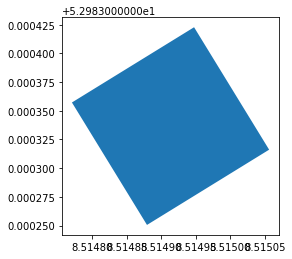

In [262]:
circle_by_poitn_df.plot()

In [256]:
circle_by_poitn_df.h3.polyfill_resample(3)

ValueError: H3 method raised an error. Is the H3 address correct?
Caller: h3_to_geo_boundary(nan)
Original error: TypeError("Argument 'h' has incorrect type (expected str, got float)")

In [69]:
circle_by_poitn_df_h3

,index,geometry
h3_polyfill,,
833f8cfffffffff,0,"POLYGON ((15.67935 28.55677, 15.69736 27.87907..."
833912fffffffff,0,"POLYGON ((-9.39799 36.68397, -9.96449 36.21506..."
83091dfffffffff,0,"POLYGON ((2.22867 65.49345, 1.34872 65.79821, ..."
8338cbfffffffff,0,"POLYGON ((8.07596 26.18440, 8.13904 25.52381, ..."
8308a1fffffffff,0,"POLYGON ((13.10360 61.67349, 13.15628 61.20073..."
...,...,...
831952fffffffff,0,"POLYGON ((-6.19984 54.79442, -6.95215 54.42981..."
835961fffffffff,0,"POLYGON ((9.49047 24.27756, 9.54440 23.61585, ..."
8338edfffffffff,0,"POLYGON ((6.93047 31.08032, 7.00344 30.42283, ..."


In [20]:
circle_by_poitn_df_h3

,index,geometry
h3_polyfill,,
8708164d2ffffff,0,"POLYGON ((11.51583 61.68771, 11.51722 61.67815..."
871946644ffffff,0,"POLYGON ((-1.09721 54.14412, -1.11257 54.13745..."
87098b2b1ffffff,0,"POLYGON ((10.73512 61.36915, 10.73666 61.35955..."
871faa0f3ffffff,0,"POLYGON ((9.22652 49.00308, 9.22801 48.99119, ..."
871f8a203ffffff,0,"POLYGON ((10.85643 46.43315, 10.85763 46.42081..."
...,...,...
871f99856ffffff,0,"POLYGON ((9.55995 45.90715, 9.56133 45.89479, ..."
871f0841cffffff,0,"POLYGON ((15.97206 53.60099, 15.97251 53.58968..."
871f11d8bffffff,0,"POLYGON ((9.63865 52.70490, 9.64015 52.69361, ..."


In [88]:
circle_by_poitn_df_h3

,index,geometry
h3_polyfill,,
861876a87ffffff,0,"POLYGON ((-5.90321 50.39957, -5.95039 50.38837..."
86180e857ffffff,0,"POLYGON ((-10.31755 51.12652, -10.36567 51.113..."
86094ccc7ffffff,0,"POLYGON ((13.05067 71.09468, 13.12036 71.11141..."
861f1e947ffffff,0,"POLYGON ((11.27678 52.41656, 11.26237 52.38666..."
8608c629fffffff,0,"POLYGON ((23.68835 65.70050, 23.73552 65.68097..."
...,...,...
861124427ffffff,0,"POLYGON ((24.72652 60.95751, 24.76664 60.93622..."
860903037ffffff,0,"POLYGON ((-0.96976 65.26364, -1.00321 65.28673..."
861f9e08fffffff,0,"POLYGON ((6.50770 45.08962, 6.49691 45.05697, ..."


In [84]:
circle_by_poitn_df

,geometry
0,"POLYGON ((8.51564 52.98327, 8.51564 52.98327, ..."


In [80]:
circle_by_poitn_df

,geometry
0,"POLYGON ((1113629.307 1610842.454, 1113629.307..."


In [57]:
##Here i am creating a point (out of test reasons, actually it would be all points in the geodataframe) 
## in crs 3764 that uses meters as the measurement metric, buffer that point for 10 meter in its radius and 
## change that polygon into the h3 grid system
## -->why ?? for counting the overlaps of circles in the oldenburg region
#POINT(8.14502 53.05857)


point = Point(1087093,1613391)
circle_by_poitn_df = geopd.GeoDataFrame(geometry=[point], crs=3763)
#circle_by_poitn_df['geometry'] = circle_by_poitn_df['geometry'][0].buffer(10,0)

circle_by_poitn_df = circle_by_poitn_df.to_crs(4326)
circle_by_poitn_df_h3 = circle_by_poitn_df.h3.polyfill(7)
#circle_by_poitn_df_h3.crs
circle_by_poitn_df_h3

TypeError: Unknown type <class 'shapely.geometry.point.Point'>

In [103]:
point = Point(8.60835,52.93122)
circle_by_poitn = point.buffer(10, 0)
circle_by_poitn_df = geopd.GeoDataFrame(geometry=[circle_by_poitn], crs=4326)
circle_by_poitn_df_h3 = circle_by_poitn_df.h3.polyfill(3, explode=True)
circle_by_poitn_df_h3

,geometry,h3_polyfill
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",831962fffffffff
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",830988fffffffff
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",83194efffffffff
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",83098afffffffff
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",831facfffffffff
...,...,...
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",8309b6fffffffff
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",831fa6fffffffff
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",830983fffffffff
0,"POLYGON ((18.60835 52.93122, 18.41620 50.98032...",831fb1fffffffff


In [ ]:
#qeqweq = geopd.GeoDataFrame(geometry=[gdf['geometry'].iloc[0]], crs=3763)
#qqqq = qeqweq.to_crs(4326)
#qqqq.geometry
#qqqq.h3.polyfill_resample(7)


In [ ]:
#qwe = test.set_geometry('noise_pollution_area')
#qwe = qwe.to_crs(4326)
#qwe= qwe.rename(columns={"noise_pollution_area": "geometry"})
#qwe

In [ ]:
test = geopd.GeoDataFrame([geo_oldenburg.iloc[0]], crs=4326)
#test = test.append(geo_oldenburg.iloc[0])
test = test.set_geometry('movement_area')

test = test.drop(columns=['geometry', 'noise_pollution_area'])
test = test.rename(columns={'movement_area':'geometry'})
test.h3.polyfill(8)

In [ ]:
#box2 = geopd.GeoDataFrame(geometry=[box(adsa.bounds[0], adsa.bounds[1], adsa.bounds[2], adsa.bounds[3])])
#gdf = geopd.GeoDataFrame(geometry=[test['noise_pollution_area'][0]],crs=3763)
#qweqw = gdf.to_crs(4326)
#qweqw.h3.polyfill(9)



In [ ]:
#gdf = geopd.GeoDataFrame(geometry=[test['noise_pollution_area'][0]],crs=3763)
#qqqq = qeqweq.to_crs(4326)
#qq = qqqq.h3.polyfill_resample(8)
#qq.plot()

In [ ]:
#noise_level= oldenburdf['geometry'].apply(lambda x: x.buffer(100, cap_style=1))
#tas = geopd.GeoDataFrame(noise_level, crs=3763)
#wq = test.to_wkt()
#test['wkt'] = pd.Series(map(lambda geom: str(test.to_wkt()), test['geometry']),index=test.index, dtype='string')
#wq['wkt']
#asd = tas.dissolve()
#asd['geometry'].values[0]
#tas.plot(color='green', figsize=(10, 10), markersize=5)
#affected_area_by_people
#er = oldenburdf['geometry']
#er.apply(lambda x: print(x))

## simulation of people moving in a ploygon
while len(spawned_people_geodf['history'][0]) < 1000:    
    spawned_people_geodf= spawned_people_geodf.apply(simulateMovement, axis=1)
    #df = pd.DataFrame(spawned_people_geodf['history'][0]).set_index('t')
    gdf = geopd.GeoDataFrame(spawned_people_geodf, crs=CRS(3763))
    
    gdf.plot(color='green',markersize=3, figsize=(10, 10))
    #agentsdf = gdf.to_crs(epsg=4326)
    #traj = mpd.Trajectory(agentsdf, 1)
    #test = traj.hvplot(geo=True, tiles='OSM', line_width=1, frame_width=500, frame_height=500)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.01)
    print(len(spawned_people_geodf['history'][0]))

In [ ]:
number_of_people = 50
number_of_vehicles = 50
def beginSim():
    #for index, row in gdf.iterrows():
    polygon_bounding_box = Polygon([(polygon.bounds.minx.values[0], polygon.bounds.miny.values[0]), (polygon.bounds.maxx.values[0], polygon.bounds.miny.values[0]), (polygon.bounds.maxx.values[0], polygon.bounds.maxy.values[0]), (polygon.bounds.minx.values[0], polygon.bounds.maxy.values[0])])
    for x in range(number_of_people):
        spawned_point = Point(random.uniform(polygon.bounds.minx.values[0], polygon.bounds.maxx.values[0]), random.uniform(polygon.bounds.miny.values[0], polygon.bounds.maxy.values[0]))
    moving_agent = [spawned_point,datetime.now(), []]
    peopleDictionary.append(Person(random.randint(18,50)))


In [126]:
def dB_calculator(array_of_noise):
    array_of_noise = [math.pow(10, i/10) for i in array_of_noise]
    return 10*math.log10(reduce(lambda x,y: x+y, array_of_noise))
    


In [127]:
## Measuring db noise level  10 log 10 (10^x + 10^x)

dB_calculator([100, 100])


103.01029995663981

In [ ]:
import threading
import time

exitFlag = 0

class myThread (threading.Thread):
    def __init__(self, threadID, name, counter):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter
    def run(self):
        print("Starting " + self.name)
        print_time(self.name, 100, self.counter)
        print("Exiting " + self.name)

def print_time(threadName, counter, delay):
    while counter:
        if exitFlag:
            threadName.exit()
        time.sleep(delay)
        print("%s: %s" % (threadName, time.ctime(time.time())))
        counter -= 1

# Create new threads
thread1 = myThread(1, "Thread-1", 1)
thread2 = myThread(2, "Thread-2", 2)

# Start new Threads
thread1.start()
thread2.start()


In [461]:
import os
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
import io
from pyspark.sql.functions import *

In [474]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.5,org.apache.kafka:kafka-clients:2.6.0 pyspark-shell'


In [ ]:
dfSpark = spark.createDataFrame(spawned_people_geodf)